In [1]:
import math
import torch
import hess
import matplotlib.pyplot as plt
import numpy as np
from hess.nets import Transformer

In [2]:
nx = 500
train_x = torch.linspace(0, 10, nx).unsqueeze(-1)
train_y = torch.sin(train_x * math.pi) + torch.sin(train_x)

In [3]:
optimus = Transformer(train_x, train_y, n_hidden=2, hidden_size=10,
                     activation=torch.nn.Tanh())

In [4]:
trained_pars = torch.load("../hess/saved-models/toy_regression.pt", map_location="cpu")

In [5]:
trained_pars

OrderedDict([('sequential.0.weight', tensor([[-0.3416],
                      [-0.0795],
                      [-0.0851],
                      [ 0.3641],
                      [ 1.4479],
                      [-0.0801],
                      [-0.2903],
                      [ 3.6203],
                      [-0.2919],
                      [ 0.0798]])),
             ('sequential.2.weight',
              tensor([[-0.1754,  0.6668,  0.7781,  0.1552,  0.2304,  0.7990,  0.2673, -0.3936,
                        0.4077, -0.4575],
                      [-0.2675,  0.6268,  0.8551,  0.3422, -0.3907,  0.7269, -0.8777, -0.0199,
                       -0.6237, -0.4115],
                      [-0.2404, -2.0211, -1.8860,  0.1023, -1.6048, -1.8859, -0.5284, -2.9404,
                       -0.2555,  1.9294],
                      [-0.4646,  2.2174,  2.3839,  0.9101,  2.0839,  2.3737,  1.3752,  1.5239,
                        1.4252, -2.0377],
                      [ 0.5264, -0.9205, -0.9658, -0.7263, 

In [6]:
optimus.net.load_state_dict(trained_pars)

<All keys matched successfully>

In [7]:
hessian = torch.load("../hess/saved-models/toy_hessian.pt", map_location="cpu")

In [9]:
n_test = 1000
test_x = torch.linspace(0, 20, n_test).unsqueeze(-1)
test_y = torch.sin(test_x * math.pi) + torch.sin(test_x)

In [10]:
orig_pred = optimus(test_x)

In [11]:
e_val, e_vec = np.linalg.eig(hessian)
idx = e_val.argsort()[::-1]   
e_val = torch.FloatTensor(e_val[idx].real)
e_vec = torch.FloatTensor(e_vec[:,idx].real)

### Perturb in largest e-vec basis

In [23]:
import hess.utils as utils

In [24]:
top_vecs = e_vec[:, 0:3]

In [25]:
n_pert = 10
scale = 0.05
pert_preds = torch.zeros(n_test, n_pert)

In [26]:
for jj in range(10):
    wghts = torch.randn(3)*0.01
    perturb = top_vecs.matmul(wghts.unsqueeze(-1)).t()
    perturb = perturb.div(perturb.norm()).mul(scale)
    print(perturb)
    perturb = utils.unflatten_like(perturb, optimus.net.parameters())
    for i, par in enumerate(optimus.net.parameters()):
        par.data = par.data + perturb[i]
        
    pert_preds[:, jj] = optimus(test_x).squeeze()
    
    optimus.net.load_state_dict(trained_pars)

tensor([[-2.0923e-02, -9.9148e-03, -1.0567e-02,  1.8826e-02,  3.8475e-04,
         -8.6632e-03, -8.4587e-03, -7.3526e-06, -7.9467e-03,  3.6208e-03,
         -1.1502e-03, -3.3401e-04, -3.5723e-04,  1.1970e-03,  1.8563e-03,
         -3.3687e-04, -1.0321e-03,  1.8749e-03, -1.0361e-03,  3.3546e-04,
          7.4798e-04,  6.0234e-04,  5.6194e-04, -7.7017e-04, -1.3217e-03,
          5.7856e-04,  7.0467e-04, -1.3316e-03,  7.0557e-04, -5.8063e-04,
         -4.2252e-03, -1.8060e-03, -1.9144e-03,  4.2703e-03,  4.4382e-03,
         -1.8179e-03, -4.0732e-03,  4.4351e-03, -4.0792e-03,  1.8112e-03,
          4.7631e-04,  1.3747e-04,  1.4729e-04, -4.9416e-04, -7.6058e-04,
          1.3869e-04,  4.3015e-04, -7.7454e-04,  4.3172e-04, -1.3809e-04,
          5.1688e-03,  7.3937e-04,  8.0608e-04, -5.4505e-03, -9.1909e-03,
          7.4384e-04,  4.4448e-03, -9.3542e-03,  4.4697e-03, -7.3985e-04,
         -3.4231e-03, -9.0852e-04, -9.7352e-04,  3.5915e-03,  6.3814e-03,
         -9.1678e-04, -3.0119e-03,  6.

### Perturb in smallest e-vec basis

In [27]:
bot_vecs = e_vec[:, -3:]

In [28]:
n_pert = 10
small_pert_preds = torch.zeros(n_test, n_pert)

In [29]:
for jj in range(10):
    wghts = torch.randn(3)
    perturb = bot_vecs.matmul(wghts.unsqueeze(-1)).t()
    perturb = perturb.div(perturb.norm()).mul(scale)
    print(perturb.shape)
    perturb = utils.unflatten_like(perturb, optimus.net.parameters())
    for i, par in enumerate(optimus.net.parameters()):
        par.data = par.data + perturb[i]
    small_pert_preds[:, jj] = optimus(test_x).squeeze()
    
    optimus.net.load_state_dict(trained_pars)

torch.Size([1, 220])
torch.Size([1, 220])
torch.Size([1, 220])
torch.Size([1, 220])
torch.Size([1, 220])
torch.Size([1, 220])
torch.Size([1, 220])
torch.Size([1, 220])
torch.Size([1, 220])
torch.Size([1, 220])


### Plotting

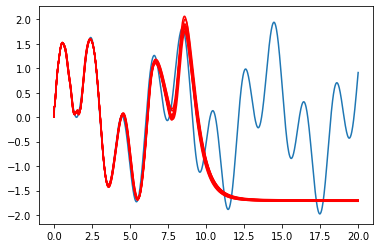

In [30]:
plt.plot(test_x, test_y.detach())
plt.plot(test_x, small_pert_preds.detach(), color="red")

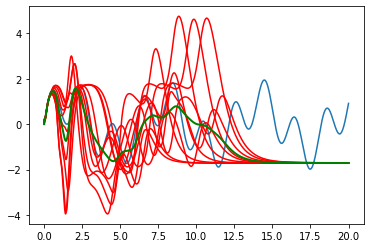

In [35]:
plt.plot(test_x, test_y.detach())
plt.plot(test_x, pert_preds.detach(), color="red")
plt.plot(test_x, pert_preds.mean(-1).detach(), color="green",
        linewidth=2.)

In [32]:
test = optimus(train_x)

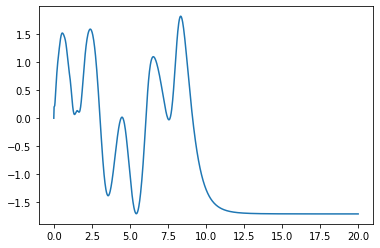

In [33]:
plt.plot(train_x, test.detach())

## Scratch

In [34]:
t1 = torch.randn(100, 1)
t2 = torch.randn(100, 1)

In [ ]:
t1.squeeze().dot(t2.squeeze())

In [ ]:
t1.norm()

In [ ]:
out = [p.data for p in optimus.net.parameters()]